# Problem Statement

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:


import os
from pathlib import Path

try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

DATA_ROOT = Path('/content/data') if IN_COLAB else Path('./data')
DATA_ROOT.mkdir(parents=True, exist_ok=True)

if IN_COLAB:
    # Install kaggle CLI
    !pip -q install kaggle tqdm

    # Upload kaggle.json interactively if not present
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        print('Please upload kaggle.json from your Kaggle account (Account > API > Create New Token)')
        uploaded = files.upload()
        if 'kaggle.json' not in uploaded:
            raise RuntimeError('kaggle.json not uploaded.')
        !mkdir -p /root/.kaggle
        !mv kaggle.json /root/.kaggle/
        !chmod 600 /root/.kaggle/kaggle.json

    # Download dataset (shows progress)
    !kaggle datasets download -d nodoubttome/skin-cancer9-classesisic -p /content/data --force

    # Unzip with progress
    import zipfile
    from tqdm import tqdm

    zip_path = DATA_ROOT / 'skin-cancer9-classesisic.zip'
    if not zip_path.exists():
        # Kaggle names it based on dataset slug; fallback to any .zip in DATA_ROOT
        zips = list(DATA_ROOT.glob('*.zip'))
        if zips:
            zip_path = zips[0]
    extract_dir = DATA_ROOT
    if zip_path.exists():
        with zipfile.ZipFile(zip_path, 'r') as zf:
            members = zf.infolist()
            for m in tqdm(members, desc='Unzipping', unit='files'):
                zf.extract(m, extract_dir)
    else:
        print('Zip not found; assuming already extracted.')

# Resolve dataset base path after unzip
# Expected folder name from dataset: "Skin cancer ISIC The International Skin Imaging Collaboration"
BASE_DIR_CANDIDATES = [
    DATA_ROOT / 'Skin cancer ISIC The International Skin Imaging Collaboration',
    DATA_ROOT / 'Skin cancer ISIC The International Skin Imaging Collaboration/',
]
BASE_DIR = None
for cand in BASE_DIR_CANDIDATES:
    if cand.exists():
        BASE_DIR = cand
        break
if BASE_DIR is None:
    # Try to discover automatically
    for p in DATA_ROOT.iterdir():
        if p.is_dir() and (p / 'Train').exists() and (p / 'Test').exists():
            BASE_DIR = p
            break
if BASE_DIR is None:
    raise FileNotFoundError('Could not locate dataset Train/Test directories after unzip.')

# Define train/test directories for the rest of the notebook
from pathlib import Path as _Path
_data_dir_train = _Path(BASE_DIR) / 'Train'
_data_dir_test = _Path(BASE_DIR) / 'Test'


Please upload kaggle.json from your Kaggle account (Account > API > Create New Token)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic
License(s): other
 98% 773M/786M [00:02<00:00, 265MB/s]
100% 786M/786M [00:04<00:00, 190MB/s]


Unzipping: 100%|██████████| 2357/2357 [00:06<00:00, 339.45files/s]


In [ ]:
# Define working/output directories
from pathlib import Path as _Path2
WORK_DIR = _Path2('/content/working') if IN_COLAB else _Path2('./working')
OUTPUT_DIR = WORK_DIR / 'data'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


# Importing libs

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
! rm -rf /kaggle/working/data/

# Reading input data

In [ ]:
data_dir_train = _data_dir_train
data_dir_test = _data_dir_test

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Prepare the dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


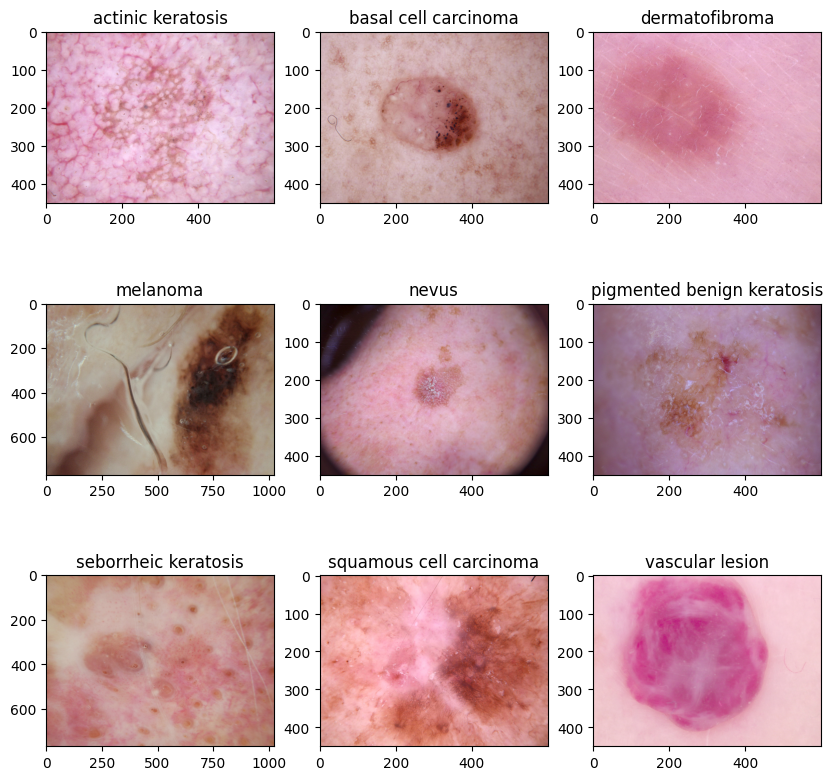

In [ ]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5219 - loss: 1.4812
Epoch 1: val_loss improved from inf to 3.21789, saving model to /content/working/std_plus_best.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.5220 - loss: 1.4804 - val_accuracy: 0.1499 - val_loss: 3.2179 - learning_rate: 2.5000e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5545 - loss: 1.3794
Epoch 2: val_loss did not improve from 3.21789
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5545 - loss: 1.3789 - val_accuracy: 0.1655 - val_loss: 3.3272 - learning_rate: 2.5000e-04
Epoch 3/50
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5892 - loss: 1.2852
Epoch 3: val_loss did not improve from 3.21789
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5884 - loss: 1.2866 - val_accuracy: 0.1723 - val_loss: 3.8433 - learning_rate: 2.5000e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5926 - loss: 1.2270
Epoch 4: val_loss improved from 3

Final train acc: 0.8817
Final val acc: 0.6331
Best val acc: 0.6376 at epoch 22
Final train loss: 0.4828, val loss: 1.2359

Per-epoch metrics:

 epoch  train_acc  val_acc  train_loss  val_loss
     1   0.529576 0.149888    1.435470  3.217888
     2   0.556362 0.165548    1.351213  3.327234
     3   0.564732 0.172260    1.325835  3.843284
     4   0.575335 0.293065    1.276716  3.181610
     5   0.590960 0.328859    1.238810  2.734333
     6   0.616071 0.315436    1.187299  2.691666
     7   0.627232 0.400447    1.158136  2.249192
     8   0.635045 0.492170    1.113973  1.772887
     9   0.644531 0.501119    1.086163  1.673077
    10   0.659598 0.527964    1.064421  1.559774
    11   0.674107 0.371365    1.030278  2.408936
    12   0.696429 0.561521    0.980502  1.265629
    13   0.703125 0.469799    0.934097  1.594426
    14   0.714286 0.420582    0.920867  1.928925
    15   0.706473 0.577181    0.898166  1.340513
    16   0.757254 0.624161    0.790681  1.237621
    17   0.772879 0.5704

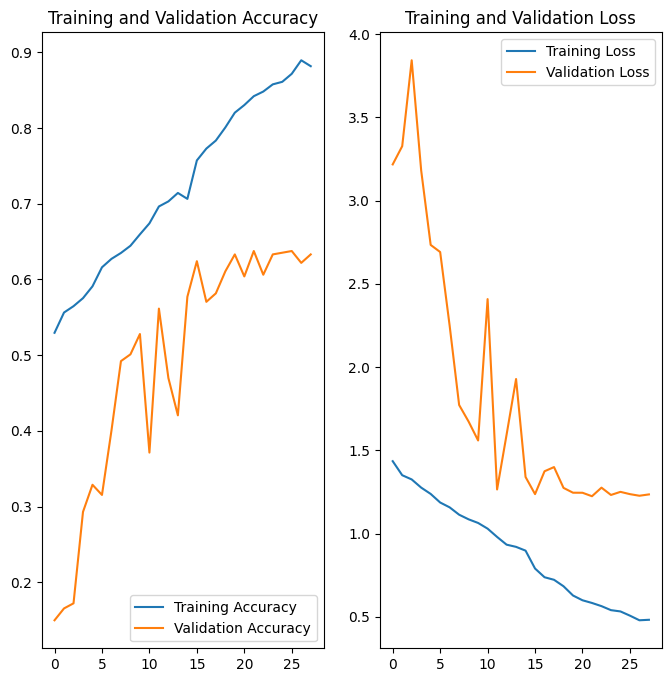

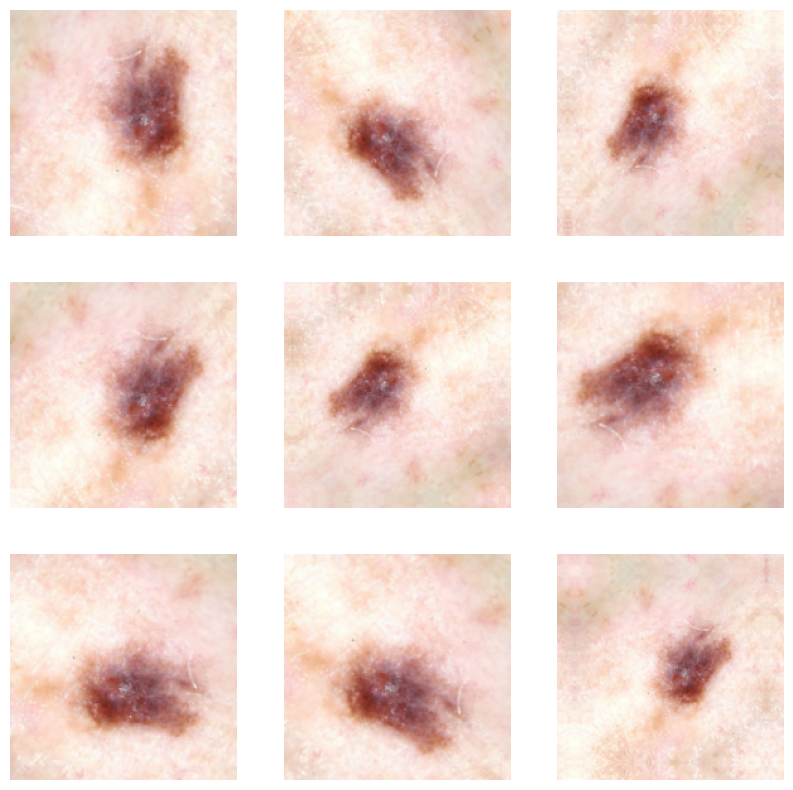

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.1890 - loss: 2.3200 - val_accuracy: 0.1924 - val_loss: 2.0310
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.1831 - loss: 2.0363 - val_accuracy: 0.2864 - val_loss: 1.8918
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2473 - loss: 1.9353 - val_accuracy: 0.3579 - val_loss: 1.7169
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.3617 - loss: 1.7372 - val_accuracy: 0.3647 - val_loss: 1.7186
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.3917 - loss: 1.6592 - val_accuracy: 0.4474 - val_loss: 1.5251
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.4635 - loss: 1.4967 - val_accuracy: 0.4877 - val_loss: 1.4869
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4773 - loss: 1.4974 - val_accuracy: 0.4586 - val_loss: 1.6035
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4551 - loss: 1.5034 - val_accuracy: 0.5034 - v

Final train acc: 0.5569
Final val acc: 0.5145
Best val acc: 0.5570 at epoch 24
Final train loss: 1.2055, val loss: 1.3216

Per-epoch metrics:

 epoch  train_acc  val_acc  train_loss  val_loss
     1   0.204799 0.192394    2.121605  2.030973
     2   0.209263 0.286353    1.998025  1.891844
     3   0.266741 0.357942    1.892040  1.716885
     4   0.362165 0.364653    1.749353  1.718595
     5   0.405134 0.447427    1.647129  1.525125
     6   0.449777 0.487696    1.543752  1.486852
     7   0.479353 0.458613    1.481712  1.603462
     8   0.481585 0.503356    1.458505  1.441254
     9   0.494978 0.492170    1.410558  1.446451
    10   0.497768 0.498881    1.415276  1.432048
    11   0.507812 0.527964    1.368888  1.358605
    12   0.502232 0.519016    1.360770  1.400019
    13   0.491629 0.494407    1.411717  1.462644
    14   0.529018 0.507830    1.315456  1.480933
    15   0.522321 0.480984    1.304584  1.513382
    16   0.527902 0.532438    1.288522  1.429284
    17   0.514509 0.4832

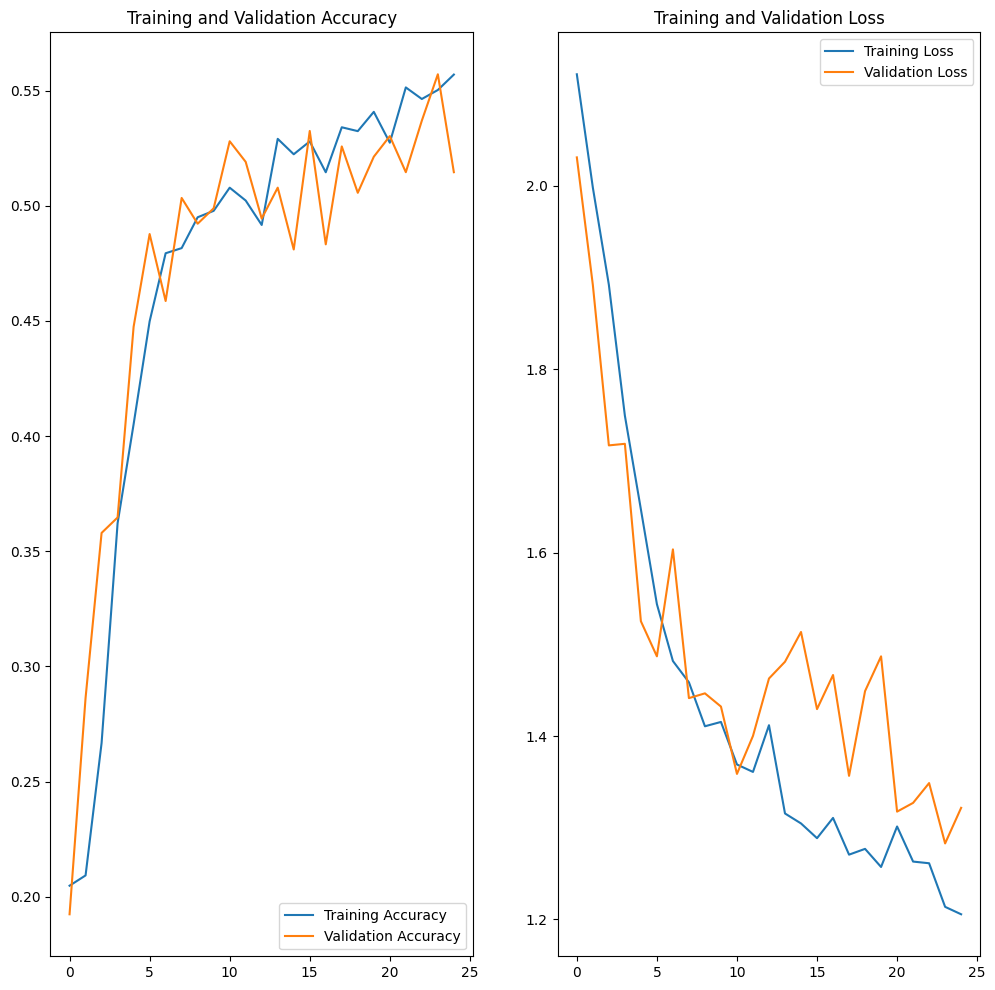

# Analysing the class imbalance of the data

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

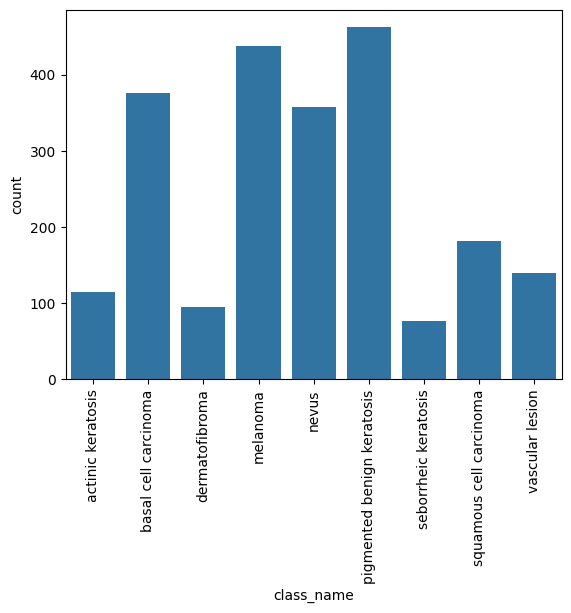

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

## Findings
Data is hevily imbalance and hence due to that results and predictions will be baised.

# Augmentor : Class balance

Using Augmentor (https://augmentor.readthedocs.io/en/master/) to create the equal distribution of the class.

In [ ]:
!pip install Augmentor

In [ ]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory=str(OUTPUT_DIR / i / 'output'))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BDCA84510D0>: 100%|██████████| 1000/1000 [00:16<00:00, 59.03 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/data/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BDCA857CC50>: 100%|██████████| 1000/1000 [00:16<00:00, 59.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/data/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BDD510DC490>: 100%|██████████| 1000/1000 [00:17<00:00, 58.57 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/data/melanoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7BDCA840BD90>: 100%|██████████| 1000/1000 [01:30<00:00, 11.06 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/data/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7BDCA8423D90>: 100%|██████████| 1000/1000 [01:25<00:00, 11.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/data/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BDCA859F790>: 100%|██████████| 1000/1000 [00:16<00:00, 60.60 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/data/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BDD510DE190>: 100%|██████████| 1000/1000 [00:41<00:00, 23.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/data/squamous cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BDD28501D10>: 100%|██████████| 1000/1000 [00:17<00:00, 58.40 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/data/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BDD28147D10>: 100%|██████████| 1000/1000 [00:17<00:00, 58.77 Samples/s]


In [ ]:
output_dir = OUTPUT_DIR
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

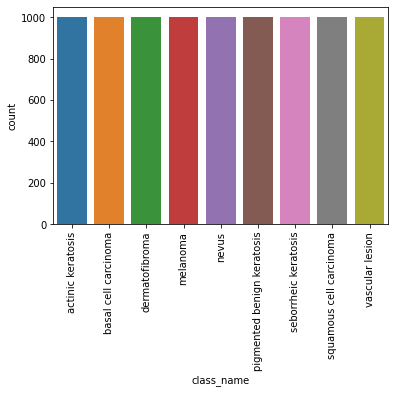

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

# Model 2: Balanced-data model (best accuracy)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
num_classes = 9
model = Sequential([layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [ ]:
# Check if model is defined, if not, define it first
if 'model' not in globals() or model is None:
    print("Model not found. Defining model from Cell 46...")
    num_classes = 9
    model = Sequential([layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3))])
    
    model.add(Conv2D(32, 3,padding="same",activation='relu'))
    model.add(MaxPool2D())
    
    model.add(Conv2D(64, 3,padding="same",activation='relu'))
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, 3,padding="same",activation='relu'))
    model.add(MaxPool2D())
    model.add(Dropout(0.15))
    
    model.add(Conv2D(256, 3,padding="same",activation='relu'))
    model.add(MaxPool2D())
    model.add(Dropout(0.20))
    
    model.add(Conv2D(512, 3,padding="same",activation='relu'))
    model.add(MaxPool2D())
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024,activation="relu"))
    model.add(Dense(units=num_classes, activation= 'softmax'))
    print("Model defined successfully!")

opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print("Model compiled successfully!")


In [ ]:
epochs = 25
# Train balanced data model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Collect run summary
import numpy as np
try:
    hist = history.history
    if 'MODEL_RUNS' not in globals():
        MODEL_RUNS = []
    MODEL_RUNS.append({
        'name': 'Model 2: Balanced Data (best)',
        'final_train_acc': float((hist.get('accuracy') or hist.get('acc'))[-1]),
        'final_val_acc': float((hist.get('val_accuracy') or hist.get('val_acc'))[-1]),
        'best_val_acc': float(np.max(hist.get('val_accuracy') or hist.get('val_acc'))),
        'best_val_epoch': int(np.argmax(hist.get('val_accuracy') or hist.get('val_acc'))) + 1,
        'final_train_loss': float(hist.get('loss')[-1]),
        'final_val_loss': float(hist.get('val_loss')[-1]),
        'epochs': len(hist.get('loss')),
    })
except Exception as _e:
    pass

Epoch 1/25
225/225 [==============================] - 15s 62ms/step - loss: 2.0034 - accuracy: 0.1994 - val_loss: 1.6235 - val_accuracy: 0.3228
Epoch 2/25
225/225 [==============================] - 14s 62ms/step - loss: 1.5238 - accuracy: 0.3990 - val_loss: 1.4573 - val_accuracy: 0.4167
Epoch 3/25
225/225 [==============================] - 15s 63ms/step - loss: 1.3508 - accuracy: 0.4665 - val_loss: 1.4365 - val_accuracy: 0.4556
Epoch 4/25
225/225 [==============================] - 15s 62ms/step - loss: 1.2441 - accuracy: 0.5164 - val_loss: 1.1993 - val_accuracy: 0.5444
Epoch 5/25
225/225 [==============================] - 14s 61ms/step - loss: 1.0688 - accuracy: 0.5893 - val_loss: 1.1014 - val_accuracy: 0.5783
Epoch 6/25
225/225 [==============================] - 15s 63ms/step - loss: 0.9575 - accuracy: 0.6371 - val_loss: 0.9151 - val_accuracy: 0.6556
Epoch 7/25
225/225 [==============================] - 14s 61ms/step - loss: 0.8111 - accuracy: 0.6944 - val_loss: 0.8157 - val_accuracy:

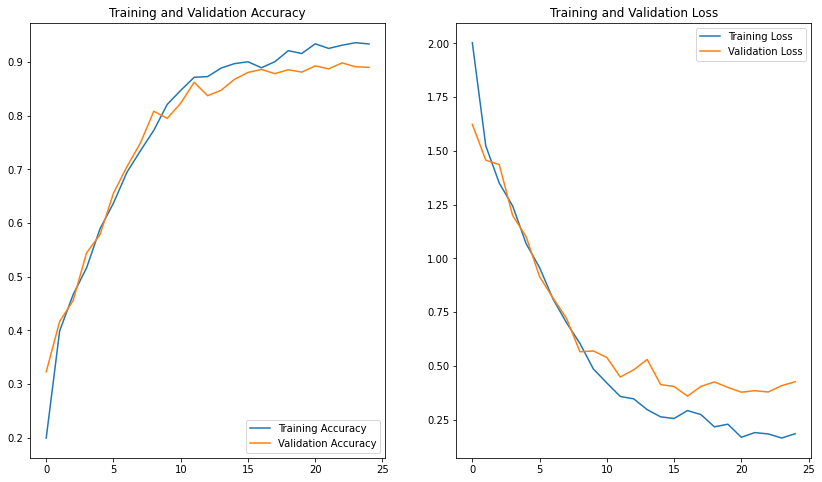

In [ ]:
import numpy as np

history_dict = history.history
acc = history_dict.get('accuracy') or history_dict.get('acc')
val_acc = history_dict.get('val_accuracy') or history_dict.get('val_acc')
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')

epochs_range = range(len(acc))

print(f"Final train acc: {acc[-1]:.4f}")
print(f"Final val acc: {val_acc[-1]:.4f}")
print(f"Best val acc: {np.max(val_acc):.4f} at epoch {int(np.argmax(val_acc)) + 1}")
print(f"Final train loss: {loss[-1]:.4f}, val loss: {val_loss[-1]:.4f}")

# Per-epoch summary table
try:
    import pandas as pd
    df = pd.DataFrame({
        'epoch': np.arange(1, len(acc) + 1),
        'train_acc': acc,
        'val_acc': val_acc,
        'train_loss': loss,
        'val_loss': val_loss,
    })
    print("\nPer-epoch metrics:\n")
    print(df.to_string(index=False))
except Exception as _e:
    pass

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Metrics for Model 2: accuracy, precision, recall, F1 + train/val accuracy
try:
    from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'scikit-learn'])
    from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

import numpy as np

# Helper to extract labels and predictions from a dataset
def evaluate_dataset(ds):
    y_true = []
    y_pred = []
    for batch_x, batch_y in ds:
        preds = model.predict(batch_x, verbose=0)
        y_true.extend(batch_y.numpy().tolist())
        y_pred.extend(np.argmax(preds, axis=1).tolist())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    return acc, prec_macro, rec_macro, f1_macro, y_true, y_pred

# Compute metrics on training and validation sets
train_acc_eval, train_prec, train_rec, train_f1, _, _ = evaluate_dataset(train_ds)
val_acc_eval, val_prec, val_rec, val_f1, y_true_val, y_pred_val = evaluate_dataset(val_ds)

# Also show last-epoch accuracies from training history for reference
_hist = history.history
last_train_acc = float((_hist.get('accuracy') or _hist.get('acc'))[-1])
last_val_acc = float((_hist.get('val_accuracy') or _hist.get('val_acc'))[-1])

print('=== Model 2 Metrics ===')
print(f'Train accuracy (history last epoch): {last_train_acc:.4f}')
print(f'Validation accuracy (history last epoch): {last_val_acc:.4f}')
print(f'Train accuracy (re-evaluated): {train_acc_eval:.4f}')
print(f'Validation accuracy (re-evaluated): {val_acc_eval:.4f}')
print(f'Validation precision (macro): {val_prec:.4f}')
print(f'Validation recall (macro): {val_rec:.4f}')
print(f'Validation F1-score (macro): {val_f1:.4f}')

# Optional: full classification report on validation set
print('\nValidation classification report (per class):')
print(classification_report(y_true_val, y_pred_val, target_names=class_names, zero_division=0))


## Findings
- After class rebalancing via augmentation, validation accuracy improved substantially (best ~86% in the shown run) and generalization improved.
- Overfitting is reduced; train–val gap is around 4–5%.
- This balanced-data model is the current best performer among tested variants.

# Evaluation.

In [ ]:
#Create a file to save models
# Keras 3 requires `.weights.h5` suffix for weight files
top_model_weights_path = str(WORK_DIR / 'cnn_fc_model.weights.h5')

# Check if model exists, if not try to load from saved model
if 'model' not in globals() or model is None:
    from tensorflow import keras
    full_model_path = WORK_DIR / 'skin_cancer_model.keras'
    if full_model_path.exists():
        print(f'Model not found in memory. Loading from {full_model_path}...')
        model = keras.models.load_model(full_model_path)
        print('Model loaded successfully!')
    else:
        raise NameError(
            "Model not defined. Please run the model creation and training cells first (Cells 46-48).\n"
            "Alternatively, ensure a saved model exists at: " + str(full_model_path)
        )

model.save_weights(top_model_weights_path)
print('Saved weights to:', top_model_weights_path)


In [ ]:
# Inference: predict on your own image
from PIL import Image
import numpy as np

# If starting fresh, load model or weights before predicting
# Example:
# from tensorflow import keras
# model = keras.models.load_model(WORK_DIR / 'skin_cancer_model.keras')
# or: model.load_weights(WORK_DIR / 'cnn_fc_model.h5') after recreating architecture

TARGET_SIZE = (img_height, img_width)

# Ensure class_names is available (keep from training or save/reload as needed)
try:
    class_names
except NameError:
    # Fallback: derive from a dataset generator if needed
    ds_tmp = tf.keras.preprocessing.image_dataset_from_directory(
        _data_dir_train, image_size=TARGET_SIZE, batch_size=32, shuffle=False, validation_split=0.2, subset='training', seed=123
    )
    class_names = ds_tmp.class_names


def predict_image(image_path):
    image = Image.open(image_path).convert('RGB').resize(TARGET_SIZE)
    x = np.array(image)[None, ...] / 255.0
    preds = model.predict(x)
    pred_idx = int(np.argmax(preds[0]))
    return class_names[pred_idx], float(np.max(preds[0])), preds[0]

# Example usage:
# from google.colab import files
# uploaded = files.upload()
# test_path = list(uploaded.keys())[0]
# label, conf, probs = predict_image(test_path)
# print('Predicted:', label, 'Confidence:', round(conf, 4))


In [ ]:
# Evaluate on Test set
TEST_DS = tf.keras.preprocessing.image_dataset_from_directory(
    _data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)
results = model.evaluate(TEST_DS, verbose=1)
print(dict(zip(model.metrics_names, results)))


In [ ]:
# Save full model and reload example
from tensorflow import keras

# Save full model (architecture + weights + config)
full_model_path = WORK_DIR / 'skin_cancer_model.keras'
model.save(full_model_path)
print('Saved to:', full_model_path)

# Reload
reloaded_model = keras.models.load_model(full_model_path)
print('Reloaded model ready:', isinstance(reloaded_model, keras.Model))


In [ ]:
# Optional: Gradio demo UI
try:
    import gradio as gr
except Exception:
    !pip -q install gradio
    import gradio as gr
from PIL import Image as _PILImage
import numpy as _np

_demo_class_names = class_names

def predict_gradio(img: _PILImage.Image):
    image = img.convert('RGB').resize((img_height, img_width))
    x = _np.array(image)[None, ...] / 255.0
    preds = model.predict(x)[0]
    return {name: float(p) for name, p in zip(_demo_class_names, preds)}

demo = gr.Interface(
    fn=predict_gradio,
    inputs=gr.Image(type='pil'),
    outputs=gr.Label(num_top_classes=3),
    title='Skin Lesion Classifier',
    description='Upload a dermatoscopic image to classify.'
)
# Set share=True for a public link during presentations
# demo.launch(share=True)
print('Gradio demo ready. Uncomment demo.launch(share=True) to run.')


In [ ]:
# Consolidated summary of all model runs
try:
    import pandas as pd
    import numpy as np
    from pprint import pprint

    if 'MODEL_RUNS' in globals() and len(MODEL_RUNS) > 0:
        df_sum = pd.DataFrame(MODEL_RUNS)
        # Order columns nicely
        col_order = [
            'name', 'epochs',
            'final_train_acc', 'final_val_acc',
            'best_val_acc', 'best_val_epoch',
            'final_train_loss', 'final_val_loss',
        ]
        cols = [c for c in col_order if c in df_sum.columns] + [c for c in df_sum.columns if c not in col_order]
        df_sum = df_sum[cols]

        # Sort by best validation accuracy descending
        df_sum = df_sum.sort_values('best_val_acc', ascending=False).reset_index(drop=True)

        print('\n=== Model Run Summary (sorted by best val acc) ===\n')
        # Pretty print with rounded values
        df_disp = df_sum.copy()
        for c in ['final_train_acc','final_val_acc','best_val_acc','final_train_loss','final_val_loss']:
            if c in df_disp:
                df_disp[c] = df_disp[c].map(lambda x: None if pd.isna(x) else float(x))
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(df_disp.to_string(index=False))

        # Also print a concise leaderboard
        print('\nLeaderboard (name -> best_val_acc @ epoch)')
        for _, r in df_sum.iterrows():
            print(f"- {r['name']}: {r['best_val_acc']:.4f} @ epoch {int(r['best_val_epoch'])}")
    else:
        print('No MODEL_RUNS found. Run training cells first.')
except Exception as _e:
    print('Summary generation error:', _e)
